<a href="https://colab.research.google.com/github/meghrajeev/llm_hw3/blob/master/11667_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !git clone https://github.com/meghrajeev/llm_hw3.git


fatal: destination path 'llm_hw3' already exists and is not an empty directory.


In [ ]:
!git config --global user.email "mrajeev@andrew.cmu.edu"
!git config --global user.name "meghrajeev"

In [1]:
!pip install datasets transformers

In [2]:
from datasets import load_dataset

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_files = {
        "train": "en.noclean/c4-train.0000[0-1]-of-07168.json.gz",
    }
dataset = load_dataset("allenai/c4", data_files=data_files, split="train")

/opt/conda/lib/python3.10/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [7]:
dataset

Dataset({
    features: ['text', 'timestamp', 'url'],
    num_rows: 296821
})

In [ ]:
dataset["text"][0]

In [ ]:
# Word Count

word_count = 0
for record in dataset:
    text = record['text']
    words = text.split()
    word_count += len(words)

print(f"Total number of words in the dataset: {word_count}")

In [5]:
from transformers import GPT2TokenizerFast
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

In [6]:
# tokenization
def tokenize_function(examples):
    return tokenizer(examples["text"], add_special_tokens=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

In [7]:
tokenized_dataset

Dataset({
    features: ['text', 'timestamp', 'url', 'input_ids', 'attention_mask'],
    num_rows: 296821
})

In [10]:
# histogram of document lengths
# Calculate the lengths of the tokenized documents
token_counts = [len(input_id) for input_id in tokenized_dataset['input_ids']]
print("Total number of tokens:", sum(token_counts))

# token_counts = []
# for document in dataset:
#     tokens = tokenizer.encode(document['text'])  
#     token_counts.append(len(tokens))
# print("Total number of tokens is {}", sum(token_counts))

Total number of tokens is {} 525090019


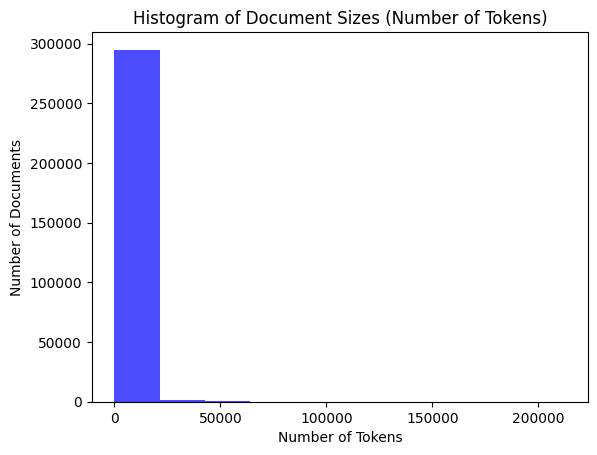

In [16]:
import matplotlib.pyplot as plt
# Plotting the histogram
plt.hist(token_counts, bins=10, color='blue', alpha=0.7)
plt.title('Histogram of Document Sizes (Number of Tokens)')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Documents')
# plt.xlim(max(token_counts))
plt.show()

In [20]:
print(f"Size of Longest Document: {max(token_counts)}", )
print(f"Size of Shortest Document: {min(token_counts)}")

Size of Longest Document: 212720
Size of Shortest Document: 1


In [21]:
token_counts

[1031,
 512,
 609,
 2946,
 912,
 1509,
 1395,
 478,
 1594,
 421,
 1395,
 21748,
 1256,
 1008,
 1204,
 721,
 1051,
 842,
 4746,
 7272,
 2825,
 137,
 2102,
 958,
 1198,
 21,
 1857,
 479,
 386,
 476,
 4083,
 7722,
 7502,
 2190,
 2846,
 1289,
 1142,
 1037,
 142,
 245,
 233,
 125,
 420,
 326,
 23,
 1396,
 1122,
 249,
 4011,
 555,
 1043,
 314,
 5,
 933,
 466,
 1931,
 1230,
 761,
 3473,
 356,
 9337,
 1440,
 3225,
 745,
 1445,
 995,
 905,
 1037,
 3215,
 542,
 2300,
 5260,
 146,
 2624,
 784,
 946,
 63,
 192,
 252,
 207,
 992,
 1593,
 556,
 2310,
 8522,
 886,
 8219,
 1477,
 87,
 515,
 2535,
 11361,
 323,
 710,
 3602,
 3908,
 520,
 257,
 3035,
 687,
 1880,
 3364,
 1710,
 34917,
 548,
 1202,
 8,
 2371,
 691,
 25766,
 699,
 1093,
 764,
 971,
 1087,
 923,
 3466,
 6367,
 863,
 4565,
 123,
 1866,
 264,
 380,
 1720,
 8782,
 3873,
 227,
 468,
 502,
 977,
 406,
 814,
 224,
 1346,
 368,
 3453,
 1165,
 784,
 620,
 3,
 88,
 1340,
 1753,
 112,
 458,
 4360,
 714,
 305,
 587,
 2027,
 145,
 654,
 440,
 572,
 90

In [26]:
import re
# Function to extract the top-level domain (like .com, .info, etc.) from a URL
def extract_only_tld(url):
    # Extracting the domain and TLD part of the URL
    domain_and_tld_match = re.search(r'//(.*?)/', url)
    if not domain_and_tld_match:
        return None
   

    domain_and_tld = domain_and_tld_match.group(1)

    parts = domain_and_tld.split('.')
    strict_tld = parts[-1] if parts else None
    # print(strict_tld)
    return strict_tld

def extract_website_names(url):
    # Extracting the domain part of the URL, including 'www' if present
    domain_match = re.search(r'://(www\.)?([^/]+)', url)
    if not domain_match:
        return None

    www_part = domain_match.group(1) if domain_match.group(1) else ''
    domain = domain_match.group(2)
    return www_part + domain

In [28]:
from collections import Counter
# Extracting TLDs and website names from URLs
tlds = [extract_only_tld(data["url"]) for data in dataset]
websites = [extract_website_names(data["url"]) for data in dataset]

# Aggregating token counts by TLD and website
tld_token_counts = Counter()
website_token_counts = Counter()

for tld, count in zip(tlds, token_counts):
    tld_token_counts[tld] += count

for website, count in zip(websites, token_counts):
    website_token_counts[website] += count


In [29]:
#  Sorting and selecting the top 25 TLDs and websites by token counts
top_25_tlds_by_tokens = dict(list(sorted(tld_token_counts.items(), key=lambda item: item[1], reverse=True))[:25])
top_25_websites_by_tokens = dict(list(sorted(website_token_counts.items(), key=lambda item: item[1], reverse=True))[:25])


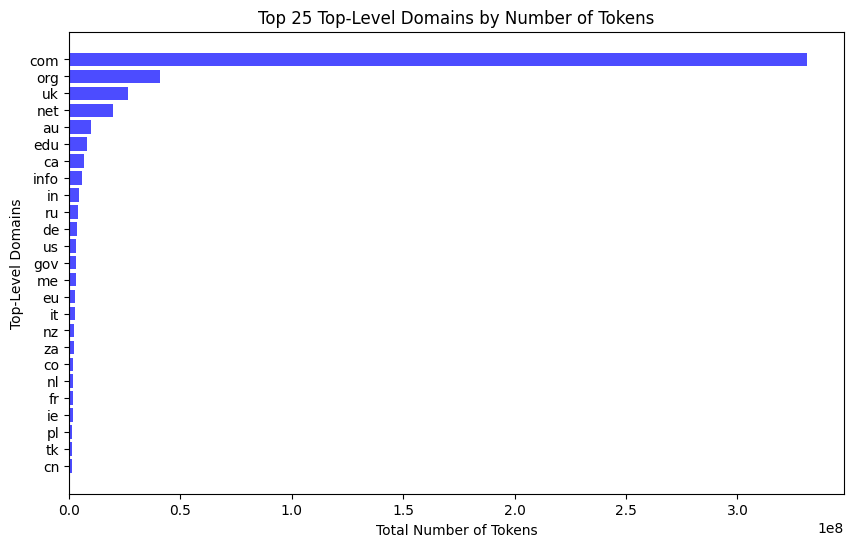

In [30]:
# Plotting the histograms
plt.figure(figsize=(10, 6))
plt.barh(list(top_25_tlds_by_tokens.keys()), top_25_tlds_by_tokens.values(), color='blue', alpha=0.7)
plt.xlabel('Total Number of Tokens')
plt.ylabel('Top-Level Domains')
plt.title('Top 25 Top-Level Domains by Number of Tokens')
plt.gca().invert_yaxis()
plt.show()

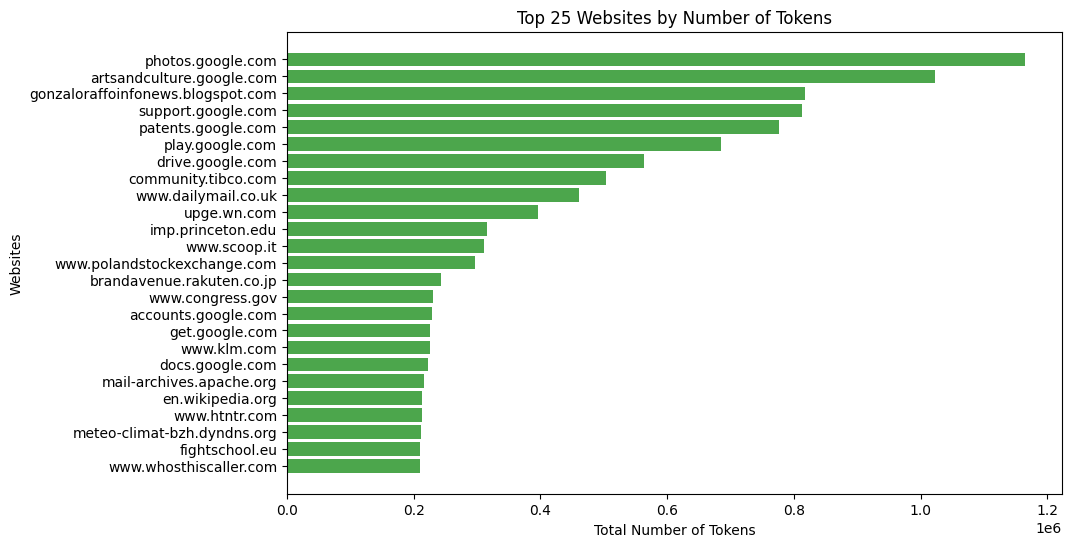

In [31]:
plt.figure(figsize=(10, 6))
plt.barh(list(top_25_websites_by_tokens.keys()), top_25_websites_by_tokens.values(), color='green', alpha=0.7)
plt.xlabel('Total Number of Tokens')
plt.ylabel('Websites')
plt.title('Top 25 Websites by Number of Tokens')
plt.gca().invert_yaxis()
plt.show()